In [3]:
%matplotlib inline

In [ ]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
# from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

sns.set_style("white")

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)


samin, samax = -11, 11

In [3]:
ncfiles = {}

ncdata = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# import baseline data 
baseline_sim = xr.open_dataset(
    os.path.join('/raid/gergel/rasm/R1009RBRceap01a/lnd/monthly_mean_timeseries', 
                'R1009RBRceap01a.vic.hmm.197909-201412.nc'))
hist_dir = '/raid/gergel/rasm/rasm_project_meeting_mar2017'
# baseline sim: 
run_rasm_atm_ice = 'wrfphys_05_rsnw105'
run_15_32_c = 'R1015aRBRcbaa01a'
run_15_37_a = 'R1015aRBRadfa01a'
run_15_37_b = 'R1015aRBRadfb01a'
run_15_37_c = 'R1015aRBRadfc01a'

# comparisons: 
# 1. rasm_atm_ice to 15_32_c
# 2. 15_32_c to 15_37_c
# 3. 15_37_c to 15_37_a
# 4. 15_37_a to 15_37_b

# load rest of data
ncdata['baseline_sim_trunc'] = xr.open_dataset(os.path.join(hist_dir, run_rasm_atm_ice, 
                                                            'wrfphys_05_rsnw105.vic.hmm.197909-198911.nc'))
ncdata['15_32_c'] = xr.open_dataset(os.path.join(hist_dir, run_15_32_c, 
                                                            'R1015aRBRcbaa01a.vic.hmm.197909-198911.nc'))
ncdata['15_37_a'] = xr.open_dataset(os.path.join(hist_dir, run_15_37_a, 
                                                            'R1015aRBRadfa01a.vic.hmm.197909-198911.nc'))
ncdata['15_37_b'] = xr.open_dataset(os.path.join(hist_dir, run_15_37_b, 
                                                            'R1015aRBRadfb01a.vic.hmm.197909-198911.nc'))
ncdata['15_37_c'] = xr.open_dataset(os.path.join(hist_dir, run_15_37_c, 
                                                            'R1015aRBRadfc01a.vic.hmm.197909-198910.nc'))

ncdata['rasm_domain'] = xr.open_dataset(ncfiles['rasm_domain'])
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])

In [4]:
'''# import rest of data 
ncdata['wrf_70'] = xr.open_dataset(
    os.path.join(
        '/raid2/jhamman/projects/RASM/data/processed/wrf371_70/lnd/monthly_mean_timeseries',
    'wrf371_70.vic.hmm.197909-199012.nc'))
ncdata['wrf_71'] = xr.open_dataset(
    os.path.join(
        '/raid2/jhamman/projects/RASM/data/processed/wrf371_71/lnd/monthly_mean_timeseries',
    'wrf371_71.vic.hmm.197909-199012.nc'))
ncdata['rasm_domain'] = xr.open_dataset(ncfiles['rasm_domain'])
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])'''

"# import rest of data \nncdata['wrf_70'] = xr.open_dataset(\n    os.path.join(\n        '/raid2/jhamman/projects/RASM/data/processed/wrf371_70/lnd/monthly_mean_timeseries',\n    'wrf371_70.vic.hmm.197909-199012.nc'))\nncdata['wrf_71'] = xr.open_dataset(\n    os.path.join(\n        '/raid2/jhamman/projects/RASM/data/processed/wrf371_71/lnd/monthly_mean_timeseries',\n    'wrf371_71.vic.hmm.197909-199012.nc'))\nncdata['rasm_domain'] = xr.open_dataset(ncfiles['rasm_domain'])\nncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])"

In [5]:
# add variables or adjust units of datasets if necessary
for r in ['baseline_sim_trunc', '15_32_c', '15_37_a', '15_37_b', '15_37_c']: 
    ncdata[r]['calc_albedo'] = 1 - (ncdata[r]['Swnet'] / ncdata[r]['Swin'])
    ncdata[r]['Swup'] = ncdata[r]['Swin'] - ncdata[r]['Swnet']
    ncdata[r]['Lwup'] = ncdata[r]['Lwin'] - ncdata[r]['Lwnet']
    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    ncdata[r]['Radnet'] = ncdata[r]['Swnet'] + ncdata[r]['Lwnet']
    ncdata[r]['Radin'] = ncdata[r]['Swin'] + ncdata[r]['Lwin']
    ncdata[r]['runoff_ratio'] = ncdata[r]['runoff_tot'] / ncdata[r]['Precipitation']
    ncdata[r]['bowen_ratio'] = ncdata[r]['Senht'] / ncdata[r]['Latht']
    ncdata[r]['evap_frac'] = ncdata[r]['Latht'] / (ncdata[r]['Latht'] + ncdata[r]['Senht'])
    ncdata[r]['P-E'] = ncdata[r]['Precipitation'] - ncdata[r]['Evap']

In [6]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])
spatial_plot_mask = ncdata['rasm_masks']['mask_active_land'].values < 0.9

In [7]:
pop_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')
wrf_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc')

ar9v4_map = make_bmap(projection=projections['wr50a'],
                      lons=pop_masks['longitude'].values,
                      lats=pop_masks['latitude'].values)

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def colorbar_index(ncolors, cmap, ticklabels=None):
    cmap = cmap_discretize_2(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, shrink=cbar_shrink, pad=0.01)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    if ticklabels is None:
        colorbar.set_ticklabels(range(ncolors))
    else:
        colorbar.set_ticklabels(ticklabels)
    return colorbar

def cmap_discretize_2(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [9]:
def plot2(plot_data,
          cmap='Spectral_r',
          amap='RdBu_r',
          ylabels=None,
          titles=('DJF', 'MAM', 'JJA', 'SON', 'ANNUAL'),
          suptitle=None,
          cbar_label='',
          abar_label='',
          vmin=None,
          vmax=None,
          amin=None,
          amax=None,
          cbar_extend='neither',
          abar_extend='neither',
          stack_cbars=False,
          map_obj=default_map,
          anom_hatching=None):
    """"""
    ncols = 5
    nrows = 3
    
    # Make sure plot_data is the right size
    grid_shape = map_obj.xi.shape
    assert(map_obj.xi.shape == map_obj.yi.shape)
    assert(map_obj.xi.shape == plot_data.shape[2:])
    assert(plot_data.shape[:2] == (nrows, ncols))
    
    # set data ranges
    if vmin is None:
        vmin = plot_data[:2].min()
    if vmax is None:
        vmax = plot_data[:2].max()
    if amin is None:
        amin = plot_data[2].min()
    if amax is None:
        amax = plot_data[2].max()
    
    # Set colorbar norms and ticks
    assert(type(cmap) == str)
    cn = 10
    cmap = cmap_discretize(cmap, n_colors=cn)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cticks = np.linspace(vmin, vmax, num=cn + 1)
    assert(type(amap) == str)
    an = 10
    amap = cmap_discretize(amap, n_colors=an)
    anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
    aticks = np.linspace(amin, amax, num=an + 1)

    if abar_label and not cbar_label:
        cbar_label = abar_label
    
    # Copy colormap and data ranges to iterables
    cmaps = (cmap, cmap, amap)
    vmins = (vmin, vmin, amin)
    vmaxs = (vmax, vmax, amax)

    # Make the plot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 5.5))
    for (i, j), ax in np.ndenumerate(axes):
        plt.sca(ax)
        sub_plot_pcolor(plot_data[i, j],
                        cmap=cmaps[i],
                        cbar=None,
                        vmin=vmins[i],
                        vmax=vmaxs[i],
                        map_obj=map_obj,
                        ax=ax)
        if i == 0 and titles is not None:
            ax.set_title(titles[j])
        if j == 0 and ylabels is not None:
            ax.set_ylabel(ylabels[i])
        if i == nrows - 1 and anom_hatching is not None:
            map_obj.m.contourf(map_obj.xi, map_obj.yi,
                               100 * (anom_hatching[j]),
                               [0,5],
                               cmap=plt.get_cmap('gray'),
                               hatches=['....', None],
                               alpha=0,
                               ax=ax)
            
    # Add figure title
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, fontweight='roman', y=1.02)
    plt.tight_layout()

    # Color bars
    if stack_cbars:
        ax1 = fig.add_axes([0.995, 0.37, 0.015, 0.54])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='vertical',
                                        extend=cbar_extend,
                                        ticks=cticks)
        ax2 = fig.add_axes([0.995, 0.08, 0.015, 0.23])
        cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                        orientation='vertical',
                                        extend=abar_extend,
                                        ticks=aticks,
                                        extendfrac=0.12)
        if cbar_label:
            cb1.set_label(cbar_label, rotation=90)
            cb2.set_label(abar_label, rotation=90)
        
    else:
        ax1 = fig.add_axes([0.995, 0.08, 0.015, 0.83])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='vertical',
                                        extend=cbar_extend,
                                        ticks=cticks)
        ax2 = fig.add_axes([1.05, 0.08, 0.015, 0.83])
        cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                        orientation='vertical',
                                        extend=abar_extend,
                                        ticks=aticks)
        if cbar_label:
            cb1.set_label(cbar_label, y=0.005, labelpad=-10, rotation=0)
        if abar_label:
            cb2.set_label(abar_label, y=0.005, labelpad=-10, rotation=0)
    
    return fig, axes

In [10]:
def plot_n(monthly_means, 
           annual_means=False,
           cmap='Spectral_r',
           amap='RdBu_r',
           vmin=None,
           vmax=None,
           amin=None,
           amax=None,
           map_obj=wr50a_map,
           cbar_label='',
           abar_label='',
           cbar_extend='neither',
           abar_extend='neither',   
           mask=None,
           mask_sig=0.01,
           standarize=False):

    ''''''

    nrows = len(monthly_means)
    if annual_means:
        ncols = 5
    else:
        ncols = 4

    width = 11
    height = 1.55 * nrows + 0.6
   
    # Set colorbar norms and ticks
    assert(type(cmap) == str)
    cn = 10
    cmap = cmap_discretize(cmap, n_colors=cn)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cticks = np.linspace(vmin, vmax, num=cn + 1)
    assert(type(amap) == str)
    an = 11
    amap = cmap_discretize(amap, n_colors=an)
    anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
    aticks = np.linspace(amin, amax, num=an + 1)
    
    fill_color = (0.9, 0.9, 0.9)
    hatch = '..'

    if abar_label and not cbar_label:
        cbar_label = abar_label
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), squeeze=False)

    plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.9,
                        wspace=0.05, hspace=0.05)
                           
    for i, (k, ds) in enumerate(monthly_means.items()):
        
        if i == 0:
            i0_ylabel = k
            axes[i, 0].set_ylabel(i0_ylabel)
            seas_mean0 = season_mean(ds)
            
            if standarize:
                stds = ds.resample('Q-Nov', dim='time', how='mean').groupby('time.season').std(dim='time')
            
            if mask_sig:
                seas_mean0_ts = dict(ds.groupby('time.season'))
            else:
                prob = 1
            
            for j, season in enumerate(seasons):
                plt.sca(axes[i, j])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_invalid(np.ma.masked_where(mask, seas_mean0.sel(season=season).values.squeeze())),
                                cmap=cmap,
                                map_obj=map_obj,
                                ax=axes[i, j],
                                cbar=None,
                                vmin=vmin,
                                vmax=vmax)
                axes[i, j].set_title(season)
            if annual_means:
                ann_mean0 = annual_mean(ds)
                
                if standarize:
                    stda = ds.resample('A', dim='time', how='mean').std(dim='time')
                
                if mask_sig:
                    ann_mean0_ts = ds.groupby('time.year').mean(dim='time')
                plt.sca(axes[i, 4])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask, ann_mean0.values.squeeze()),
                                cmap=cmap,
                                map_obj=map_obj,
                                ax=axes[i, 4],
                                cbar=None,
                                vmin=vmin,
                                vmax=vmax)
                axes[i, 4].set_title('ANNUAL')
        else:
            axes[i, 0].set_ylabel('{0}\n — {1}'.format(i0_ylabel, k))
            seas_meani = seas_mean0 - season_mean(ds)
            
            if standarize:
#                 seas_meani /= stds
                seas_meani /= ds.resample('A', dim='time', how='mean').std(dim='time')
            
            if mask_sig:
                seas_meani_ts = dict(ds.groupby('time.season'))
            
            for j, season in enumerate(seasons):
                plt.sca(axes[i, j])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask,
                                                   seas_meani.sel(season=season).values.squeeze()),
                                cmap=amap,
                                map_obj=map_obj,
                                ax=axes[i, j],
                                cbar=None,
                                vmin=amin,
                                vmax=amax)
                if mask_sig:
                    _, prob = ttest_ind(seas_mean0_ts[season].values.squeeze(),
                                        seas_meani_ts[season].values.squeeze(),
                                        axis=0,
                                        equal_var=False)
                    map_obj.m.contourf(map_obj.xi, map_obj.yi,
                                       np.ma.masked_where(mask, prob),
                                       [0, mask_sig],
                                       hatches=[hatch, None],
                                       alpha=0,
                                       ax=axes[i, j])
                
            if annual_means:
                ann_meani = ann_mean0 - annual_mean(ds)
                
                if standarize:
#                     ann_meani /= stda
                    ann_meani / ds.resample('A', dim='time', how='mean').std(dim='time')

                plt.sca(axes[i, 4])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask, ann_meani.values.squeeze()),
                                cmap=amap,
                                map_obj=map_obj,
                                ax=axes[i, 4],
                                cbar=None,
                                vmin=amin,
                                vmax=amax)
                
                if mask_sig:
                    ann_meani_ts = ds.groupby('time.year').mean(dim='time')
                    _, prob = ttest_ind(ann_mean0_ts.values.squeeze(),
                                        ann_meani_ts.values.squeeze(),
                                        axis=0,
                                        equal_var=False)
                    map_obj.m.contourf(map_obj.xi, map_obj.yi,
                                       np.ma.masked_where(mask, prob),
                                       [0, mask_sig],
                                       hatches=[hatch, None],
                                       alpha=0,
                                       ax=axes[i, 4])
    cbar_height = 0.025
    cbar_width = 0.44
    ax1 = fig.add_axes([0.06, -cbar_height, cbar_width, cbar_height])
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                    orientation='horizontal',
                                    extend=cbar_extend,
                                    ticks=cticks)
    ax2 = fig.add_axes([0.55, -cbar_height, cbar_width, cbar_height])
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                    orientation='horizontal',
                                    extend=abar_extend,
                                    ticks=aticks)
    if cbar_label:
        cb1.set_label(cbar_label) #, y=0.005, labelpad=-10, rotation=0)
    if abar_label:
        cb2.set_label(abar_label) #, y=0.005, labelpad=-10, rotation=0)
                
    plt.tight_layout(pad=.95)
    return fig, axes

In [11]:
def draw_map(lw=0.3):
    wr50a_map.m.drawmapboundary(fill_color=(0.9, 0.9, 0.9))
    wr50a_map.m.fillcontinents(color='white', zorder=0)
    wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=lw)
    wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=lw)
    wr50a_map.m.drawcoastlines(color='k', linewidth=lw)
    
def plot_n_std_anoms(monthly_means, vmin=-25, vmax=25, smin=0, smax=3, amin=-4.5, amax=4.5,
                     cmap='Spectral_r', smap='YlGnBu', amap='RdBu', cbar_extend='both',
                     sbar_extend='max', abar_extend='both', cbar_label= 'Mean', varname=None, units='-'):
    with sns.axes_style("white"):

        # Set colorbar norms and ticks
        # assert(type(cmap) == str)
        cn = 10
        cmap = cmap_discretize(cmap, n_colors=cn)
        cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cticks = np.linspace(vmin, vmax, num=cn + 1)
        # assert(type(smap) == str)
        cn = 10
        smap = cmap_discretize(smap, n_colors=cn)
        snorm = mpl.colors.Normalize(vmin=smin, vmax=smax)
        sticks = np.linspace(smin, smax, num=cn + 1)
        # assert(type(amap) == str)
        an = 9
        amap = cmap_discretize(amap, n_colors=an)
        anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
        aticks = np.round(np.linspace(amin, amax, num=an + 1), 1)

        keys = list(monthly_means.keys())

        dss = monthly_means[keys[0]].resample('QS-SEP', dim='time').groupby('time.season')
        dsa = monthly_means[keys[0]].resample('AS', dim='time')

        nrows = len(monthly_means) + 1
        ncols = 5
        width = 11
        height = 1.55 * nrows + 0.6

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(width, height),
                                 sharex=True, sharey=True)
        plt.subplots_adjust(left=0.125, bottom=0.05,
                            right=0.9, top=0.9,
                            wspace=0.05, hspace=0.05)

        season_means = dss.mean(dim='time')
        season_stds = dss.std(dim='time')

        annual_means = dsa.mean(dim='time')
        annual_stds = dsa.std(dim='time')

        # Means
        for i, season in enumerate(seasons):
            plt.sca(axes[0, i])
            draw_map()
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_means.sel(season=season).to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap)


        plt.sca(axes[0, 4])
        sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_means.to_masked_array()),
                        map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap)
        draw_map()    

        # Standard deviations
        for i, season in enumerate(seasons):
            plt.sca(axes[1, i])
            draw_map()
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_stds.sel(season=season).to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=smin, vmax=smax, cmap=smap)


        plt.sca(axes[1, 4])
        sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_stds.values.squeeze()),
                        map_obj=wr50a_map, cbar=None, vmin=smin, vmax=smax, cmap=smap)

        draw_map()

        # anomalies
        for j, key in enumerate(keys[1:]):
            dss = monthly_means[key].resample('QS-SEP', dim='time').groupby('time.season')
            dsa = monthly_means[key].resample('AS', dim='time')
            season_anoms = (season_means - dss.mean(dim='time'))
            annual_anoms = (annual_means - dsa.mean(dim='time'))

            for i, season in enumerate(seasons):
                plt.sca(axes[j + 2, i])
                draw_map()
                sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_anoms.sel(season=season).to_masked_array()),
                                map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap)


            plt.sca(axes[j + 2, 4])
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_anoms.to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap)

            draw_map()

        plt.tight_layout()

        # titles = [ax.set_title(str(title)) for title, ax in zip(list(seasons) + ['Annual'], axes[0])]
        new_seasons = list(seasons) + ['Annual']
        for i, ax in enumerate(axes[0]):
            ax.set_title(new_seasons[i])
        # ylabels = [ax.set_ylabel("{0}\n — {1}".format(keys[0], label)) for label, ax in zip(keys[1:], axes[2:, 0])]
        for label, ax in zip(keys[1:], axes[2:, 0]): 
            # ax.set_ylabel("{0}\n — {1}".format(keys[0], label))
            ax.set_ylabel("%s \n - %s" % (keys[0], label))
        axes[0, 0].set_ylabel(keys[0])
        axes[1, 0].set_ylabel("{0} (Std.)".format(keys[0]))

        # Colorbars
        cbar_height = 0.02
        cbar_width = .313
        ax1 = fig.add_axes([0.01, -cbar_height, cbar_width, cbar_height])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='horizontal',
                                        extend=cbar_extend,
                                        ticks=cticks)
        ax2 = fig.add_axes([0.343, -cbar_height, cbar_width, cbar_height])
        cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=smap, norm=snorm,
                                        orientation='horizontal',
                                        extend=sbar_extend,
                                        ticks=sticks)
        ax3 = fig.add_axes([0.673, -cbar_height, cbar_width, cbar_height])
        cb3 = mpl.colorbar.ColorbarBase(ax3, cmap=amap, norm=anorm,
                                        orientation='horizontal',
                                        extend=abar_extend,
                                        ticks=aticks)
        if varname is not None:
            cb1.set_label("{0} ({1}, Mean)".format(varname, units))
            cb2.set_label("{0} ({1}, Std.)".format(varname, units))
            cb3.set_label("{0} ({1}, Anomaly)".format(varname, units))

    return fig, axes

In [55]:
dpi = 200
plot_direc = '/raid/gergel/rasm/rasm_project_meeting_mar2017/plots'

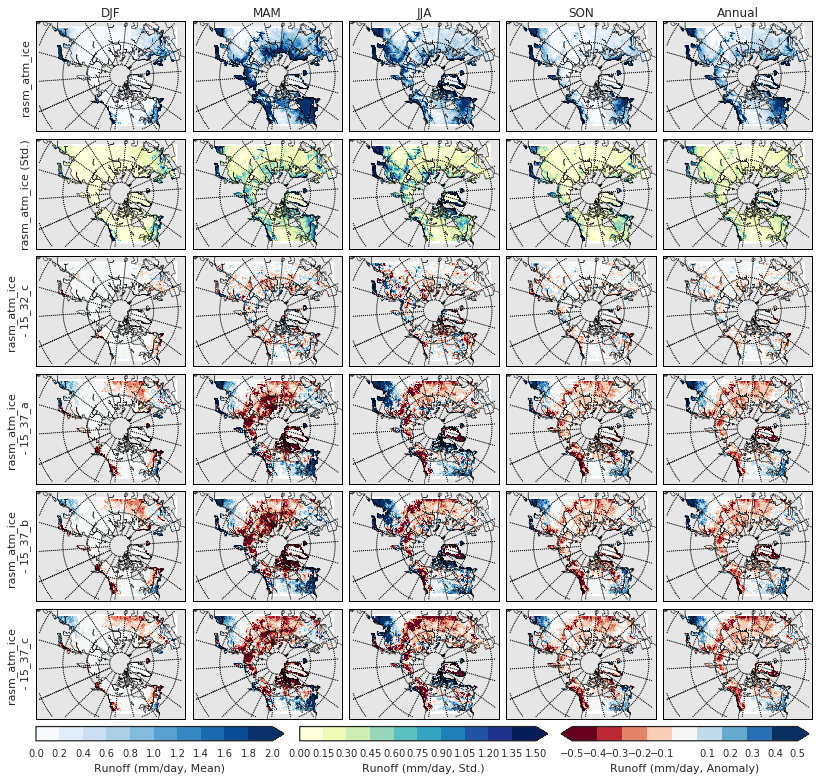

In [56]:
var = 'runoff_tot'
monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, vmin=0., vmax=2, smax=1.5, amin = -0.5, 
                             amax = 0.5, varname='Runoff', units='mm/day', cmap='Blues', amap='RdBu',
                             cbar_extend='max')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

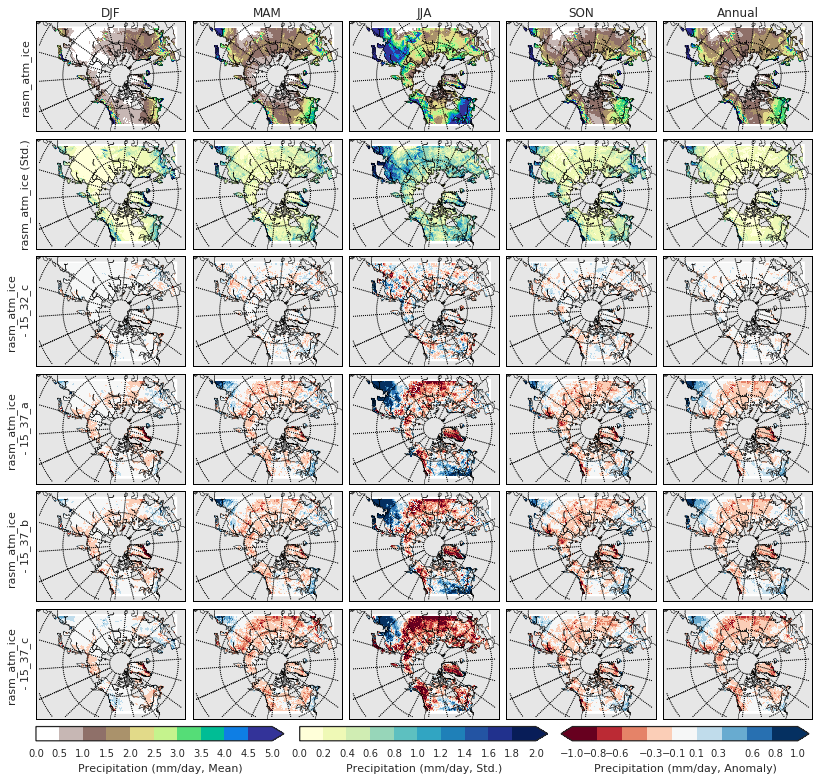

In [57]:
var = 'Precipitation'
monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, vmin=0., vmax=5, smax=2, amin = -1, 
                             amax = 1, varname='Precipitation', units='mm/day', cmap='terrain_r', amap='RdBu',
                             cbar_extend='max')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

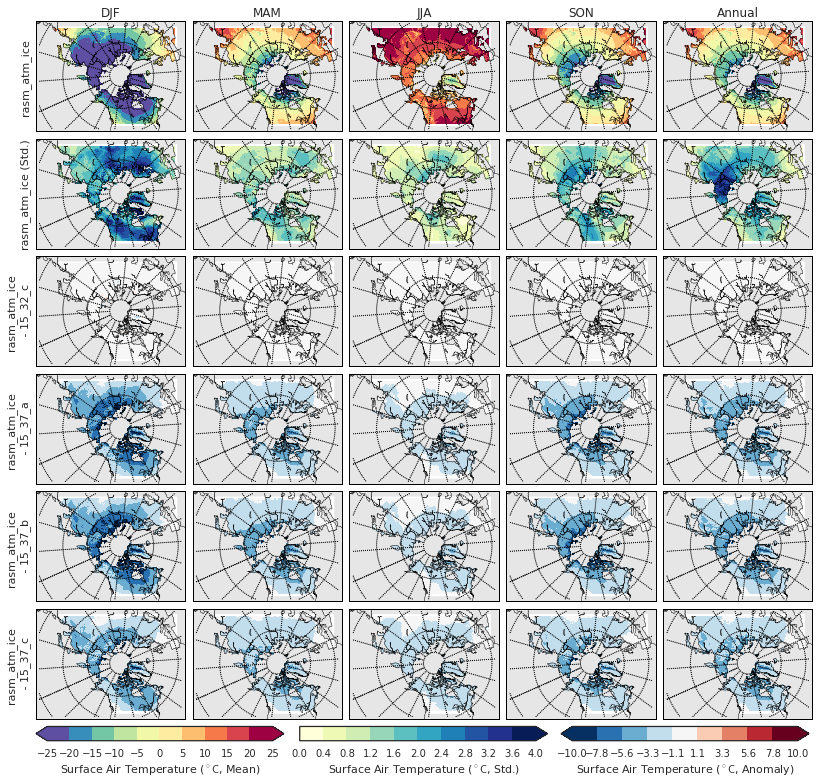

In [58]:
var = 'Tair'
monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, amin=-10, amax=10, smax=4, amap='RdBu_r',
                             varname='Surface Air Temperature', units='$^\circ C$')
plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

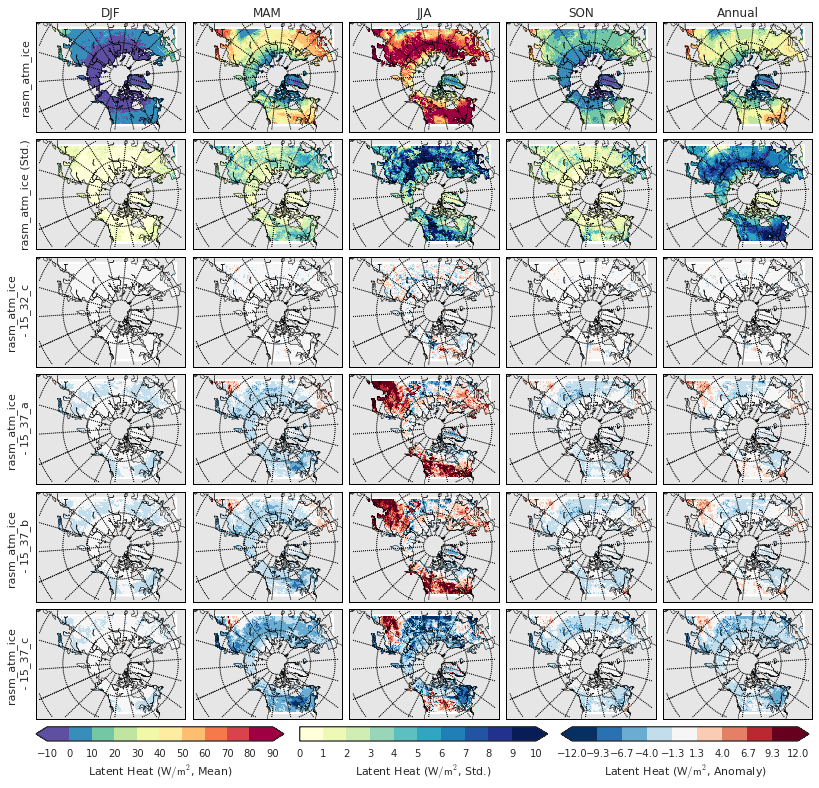

In [59]:
var = 'Latht'
monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, vmin=-10., vmax=90, smax=10, amin=-12, amax=12, amap='RdBu_r',
                             varname='Latent Heat', units='$W/m^2$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

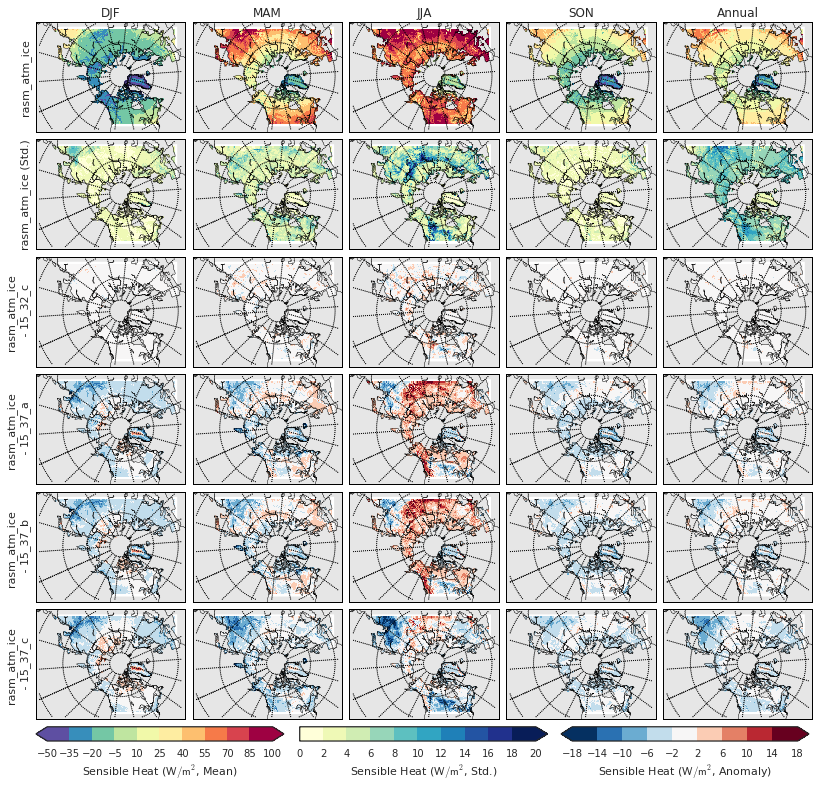

In [60]:
var = 'Senht'
monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, vmin=-50., vmax=100, smax=20, amin=-18, amax=18, amap='RdBu_r',
                             varname='Sensible Heat', units='$W/m^2$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

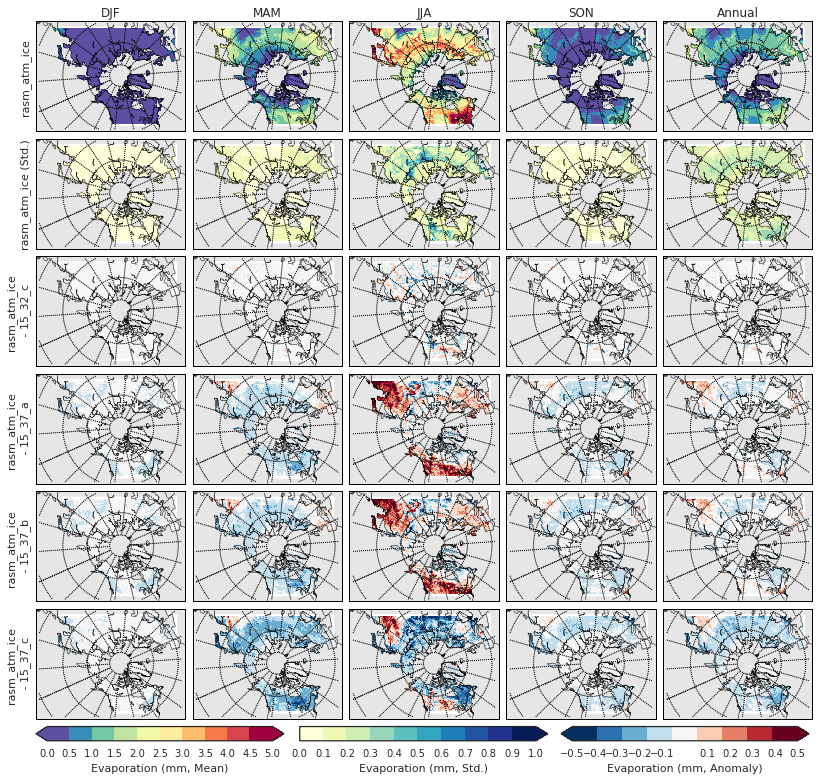

In [61]:
var = 'Evap'
var_name = 'Evaporation'
units = 'mm'

monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, smax=1, amin=-0.5, amax=0.5, vmin=0, vmax=5, amap='RdBu_r',
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

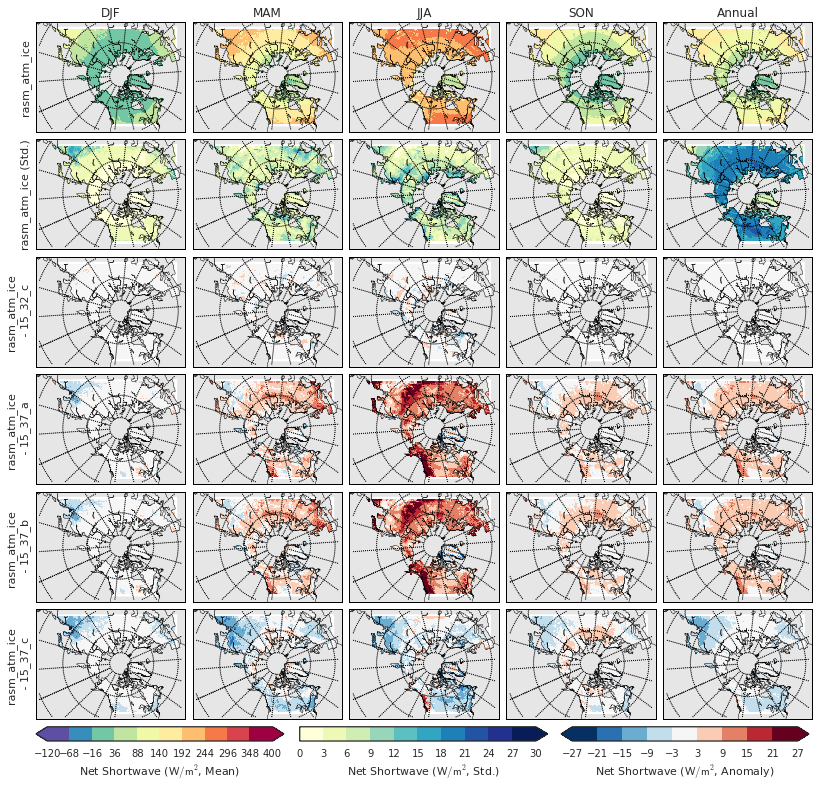

In [62]:
var = 'Swnet'
var_name = 'Net Shortwave'
units = '$W/m^2$'

monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, smax=30, amap='RdBu_r', vmin=-120, vmax=400, amin=-27, amax=27,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

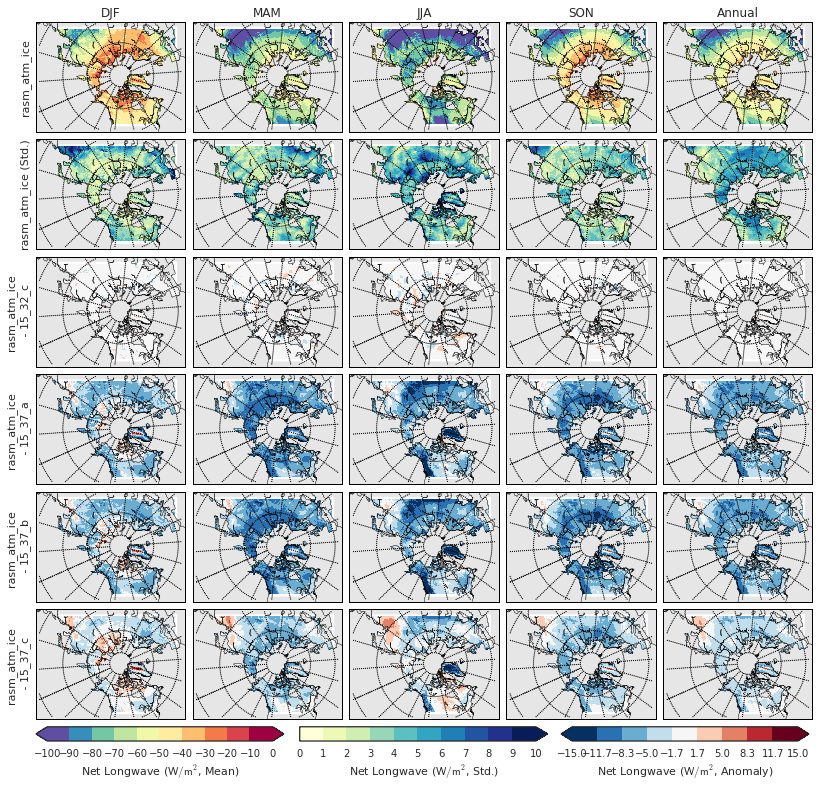

In [63]:
var = 'Lwnet'
var_name = 'Net Longwave'
units = '$W/m^2$'

monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, smax=10, amap='RdBu_r', vmin=-100, vmax=0, amin=-15, amax=15,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

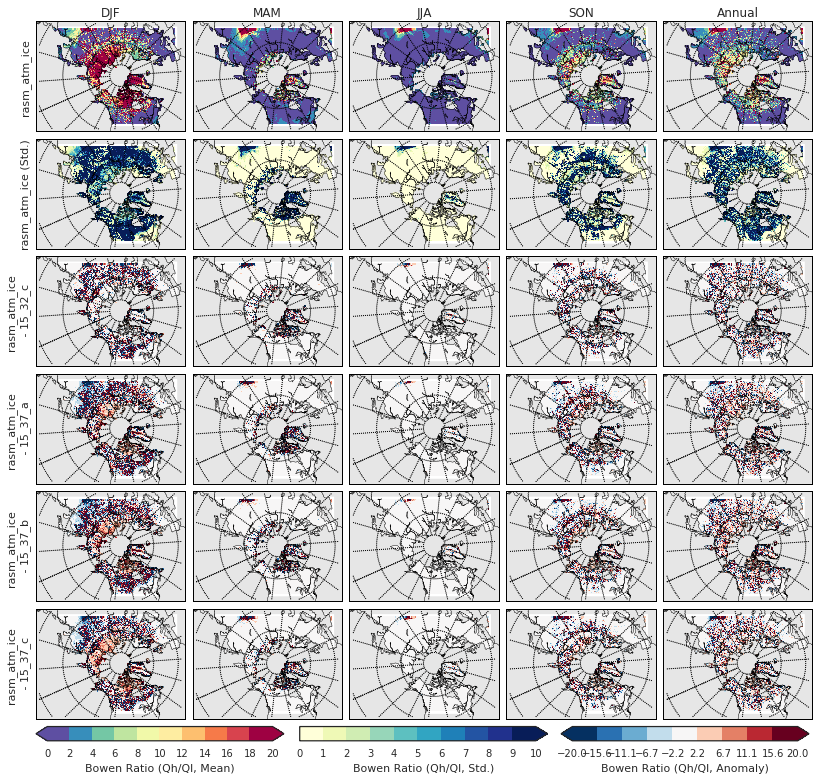

In [64]:
var = 'bowen_ratio'
var_name = 'Bowen Ratio'
units = 'Qh/Ql'

monthly_means = OrderedDict()
monthly_means['rasm_atm_ice'] = ncdata['baseline_sim_trunc'][var]
monthly_means['15_32_c'] = ncdata['15_32_c'][var]
monthly_means['15_37_a'] = ncdata['15_37_a'][var]
monthly_means['15_37_b'] = ncdata['15_37_b'][var]
monthly_means['15_37_c'] = ncdata['15_37_c'][var]

fig, axes = plot_n_std_anoms(monthly_means, smax=10, amap='RdBu_r', vmin=0, vmax=20, amin=-20, amax=20,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')